In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from modules import EDMPrecond
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Make predictions on test data

In [3]:
path = "../models/edm_e1000_bs16/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = EDMPrecond(img_resolution   = 1024,
                    img_channels    = 1,
                    label_dim       = 3,
                    use_fp16        = False,
                    sigma_min       = 0,
                    sigma_max       = float('inf'),
                    sigma_data      = 0.5,
                    model_type      = 'DhariwalUNet',
                    ).to(device)
ckpt = torch.load(path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=100)

Loading:  ../models/edm_e1000_bs16/ema_ckpt.pt
Using device: cuda


In [4]:
x_real, cond_vectors, predictions = evaluate(model,
                      sampler,
                      device,
                      "../../data/test_data_1024.csv",
                                            s_type='edm')
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop: 100%|█████████████████████████████████████████████| 1567/1567 [1:47:45<00:00,  4.13s/it]


In [5]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.21884798769246802


In [6]:
x_real

array([[0.00061579, 0.        , 0.        , ..., 0.00181409, 0.00107043,
        0.00106402],
       [0.00087057, 0.        , 0.        , ..., 0.00079498, 0.00183476,
        0.00029969],
       [0.00010624, 0.00054038, 0.        , ..., 0.        , 0.00081565,
        0.00106402],
       ...,
       [0.00112534, 0.        , 0.        , ..., 0.00054021, 0.00056087,
        0.00055447],
       [0.00087057, 0.        , 0.        , ..., 0.00155931, 0.00157998,
        0.00029969],
       [0.        , 0.        , 0.        , ..., 0.00079498, 0.0013252 ,
        0.00029969]])

In [14]:
predictions

array([[[[0.36123767, 0.24021666, 0.34457836, ..., 0.49995425,
          0.6800822 , 0.57763112]]],


       [[[0.80448186, 0.66796762, 0.65551621, ..., 0.56293941,
          0.70971304, 0.53973413]]],


       [[[0.54205853, 0.71550184, 0.64298558, ..., 0.6516667 ,
          0.70223147, 0.62896132]]],


       ...,


       [[[0.27560881, 0.41615698, 0.47906265, ..., 0.35574648,
          0.4265739 , 0.62752122]]],


       [[[0.53874058, 0.58957487, 0.50624061, ..., 0.37021711,
          0.49221331, 0.48523876]]],


       [[[0.36732236, 0.57570231, 0.82495761, ..., 0.52742451,
          0.5670169 , 0.61395574]]]])

In [15]:
predictions[:, 0, 0, :]

array([[0.36123767, 0.24021666, 0.34457836, ..., 0.49995425, 0.6800822 ,
        0.57763112],
       [0.80448186, 0.66796762, 0.65551621, ..., 0.56293941, 0.70971304,
        0.53973413],
       [0.54205853, 0.71550184, 0.64298558, ..., 0.6516667 , 0.70223147,
        0.62896132],
       ...,
       [0.27560881, 0.41615698, 0.47906265, ..., 0.35574648, 0.4265739 ,
        0.62752122],
       [0.53874058, 0.58957487, 0.50624061, ..., 0.37021711, 0.49221331,
        0.48523876],
       [0.36732236, 0.57570231, 0.82495761, ..., 0.52742451, 0.5670169 ,
        0.61395574]])

In [8]:
cond_vectors

array([[0.31632441, 0.3391147 , 0.        ],
       [0.27736008, 0.44142237, 0.        ],
       [0.67720926, 0.2812798 , 0.        ],
       ...,
       [0.40499091, 0.84475654, 0.        ],
       [0.37738329, 0.6054191 , 0.        ],
       [0.71750009, 0.09133745, 0.        ]])

# Save predictions

In [16]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv('../results/predictions/preds_edm_DhariwalUNet_1024.csv', index=False)

In [17]:
df.head()

x_real  \
0  0.0006157915922813118,0.0,0.0,0.00149204465560...   
1  0.0008705681539140642,0.0,0.0,0.00174682121723...   
2  0.0001062385126715526,0.0005403818213380873,0....   
3  0.0008705681539140642,3.082872717641294e-05,0....   
4  0.0003610150597523898,0.0,0.0,0.00123726809397...   

                                  cond_vectors  \
0    0.3163244128227234,0.3391146957874298,0.0   
1  0.27736008167266846,0.44142237305641174,0.0   
2    0.6772092580795288,0.2812798023223877,0.0   
3    0.5888327956199646,0.7273106575012207,0.0   
4   0.3009049892425537,0.22526775300502777,0.0   

                                         predictions  
0  0.36123767495155334,0.24021665751934052,0.3445...  
1  0.8044818639755249,0.6679676175117493,0.655516...  
2  0.542058527469635,0.7155018448829651,0.6429855...  
3  0.5449190139770508,0.25747475028038025,0.38812...  
4  0.1856914609670639,0.5221288204193115,0.537766...

In [18]:
# Load data
df = pd.read_csv('../results/predictions/preds_edm_DhariwalUNet_1024.csv')

# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

x_real  \
0  0.0006157915922813118,0.0,0.0,0.00149204465560...   
1  0.0008705681539140642,0.0,0.0,0.00174682121723...   
2  0.0001062385126715526,0.0005403818213380873,0....   
3  0.0008705681539140642,3.082872717641294e-05,0....   
4  0.0003610150597523898,0.0,0.0,0.00123726809397...   

                                  cond_vectors  \
0    0.3163244128227234,0.3391146957874298,0.0   
1  0.27736008167266846,0.44142237305641174,0.0   
2    0.6772092580795288,0.2812798023223877,0.0   
3    0.5888327956199646,0.7273106575012207,0.0   
4   0.3009049892425537,0.22526775300502777,0.0   

                                         predictions  
0  0.36123767495155334,0.24021665751934052,0.3445...  
1  0.8044818639755249,0.6679676175117493,0.655516...  
2  0.542058527469635,0.7155018448829651,0.6429855...  
3  0.5449190139770508,0.25747475028038025,0.38812...  
4  0.1856914609670639,0.5221288204193115,0.537766...

# Intro into data

In [19]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51206			0.47867
0.51917			0.65707
0.53315			0.38276
0.50054			0.43051
0.51451			0.39182
0.57714			0.28863
0.62085			0.40791
0.67306			0.41411
0.75889			0.27997
0.82681			0.46690
0.89323			0.24162
0.94675			0.32815
0.98621			0.49238
1.00000			0.31498
1.00000			0.37538
1.00000			0.17931
0.98376			0.42843
0.91490			0.79082
0.86643			0.30230
0.81041			0.75081
0.76278			0.57950
0.68614			0.39609
0.66184			0.23769
0.57601			0.55366
0.53988			0.56951
0.50519			0.54503
0.51203			0.49608
0.53162			0.65924
0.50025			0.57124
0.54682			0.55220
0.58773			0.64749
0.63280			0.39978
0.71023			0.66114
0.77866			0.68557
0.83973			0.58737
0.89197			0.58409
0.93576			0.40881
0.97427			0.52539
0.95795			0.32117
0.98165			0.49931
0.95217			0.56936
0.89197			0.73521
0.85242			0.39165
0.80047			0.47271
0.75615			0.61836
0.69047			0.70743
0.66184			0.81974
0.57448			0.68581
0.53402			0.67916
0.50635			0.56956


In [20]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):
0.00100			0.82019
0.00009			0.91665
0.00083			0.80932
0.00109			0.87327
0.00403			0.99622
0.00139			0.88531
0.00069			0.89787
0.00141			0.88871
0.00000			0.88892
0.00094			0.85201
0.00083			0.92707
0.00079			0.88143
0.00066			0.82545
0.00072			0.89120
0.00161			1.00000
0.00087			0.80448
0.00067			0.80827
0.00196			0.90311
0.00128			0.94572
0.00052			0.84048
0.00018			0.83497
0.00007			0.86450
0.00096			0.84299
0.00134			0.86406
0.00094			0.93522
0.00106			0.95661
0.02478			0.88058
0.07766			0.83002
0.08559			0.85395
0.08206			0.86491
0.05031			0.86366
0.03579			0.82863
0.02072			0.88469
0.01674			0.89237
0.01245			0.85943
0.00231			0.99816
0.00315			0.81803
0.00203			0.82653
0.00088			0.84587
0.00218			0.94672
0.00000			0.85085
0.00146			0.80706
0.00000			0.80122
0.00058			0.87141
0.00089			0.80407
0.00065			0.89361
0.00104			0.90411
0.00071			0.95233
0.00177			0.89549
0.00285			0.80905
0.00062			0.81126
0.002

# Visualization of results

In [22]:
wavelengths = np.load('../../data/wavelengths.npy')

In [23]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

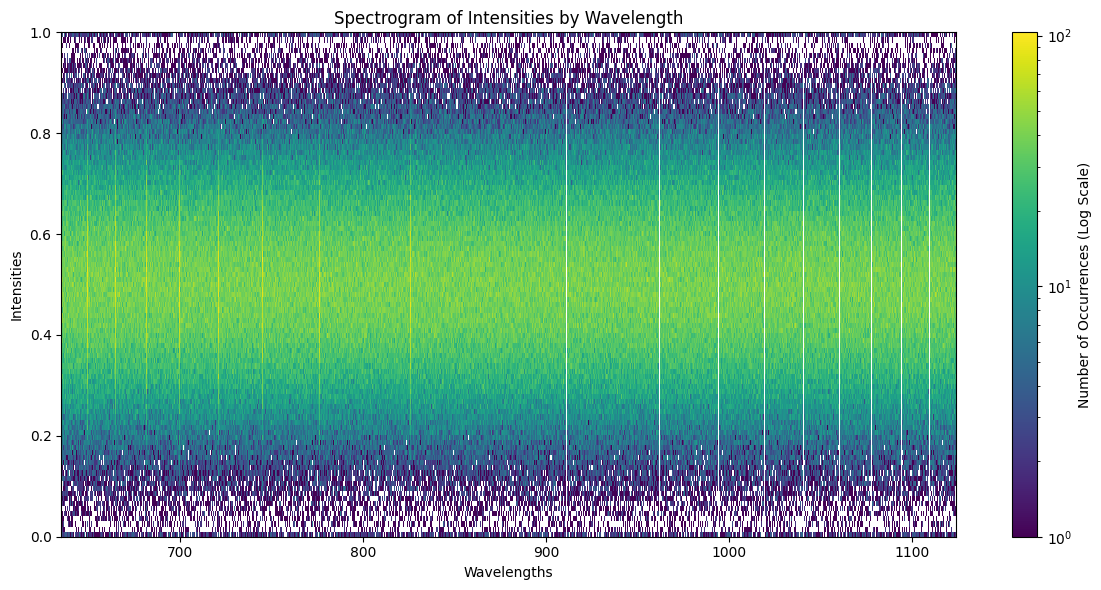

In [24]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

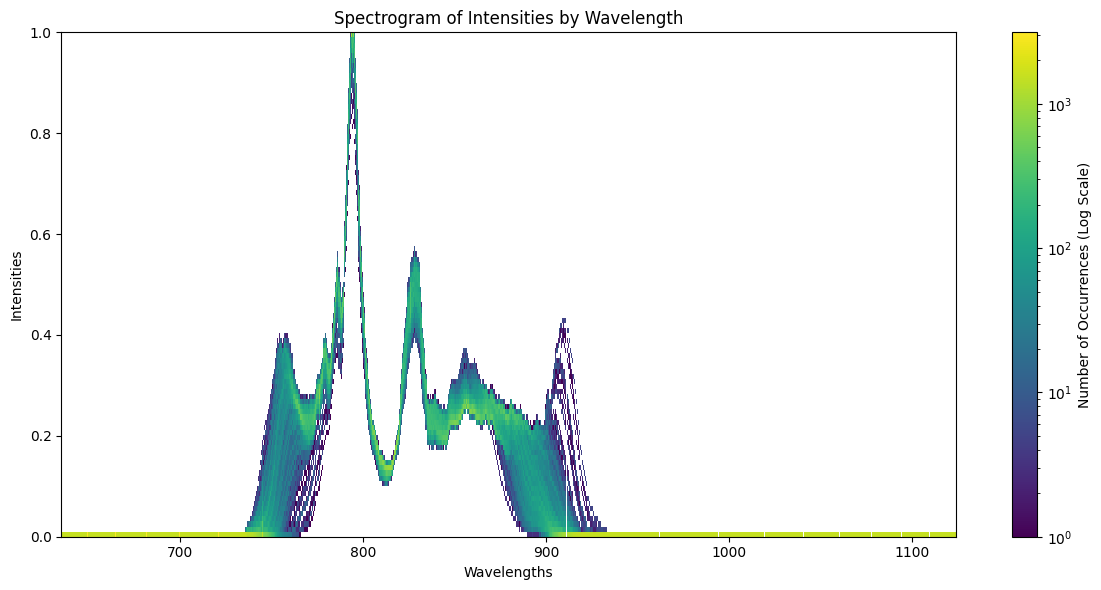

In [25]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

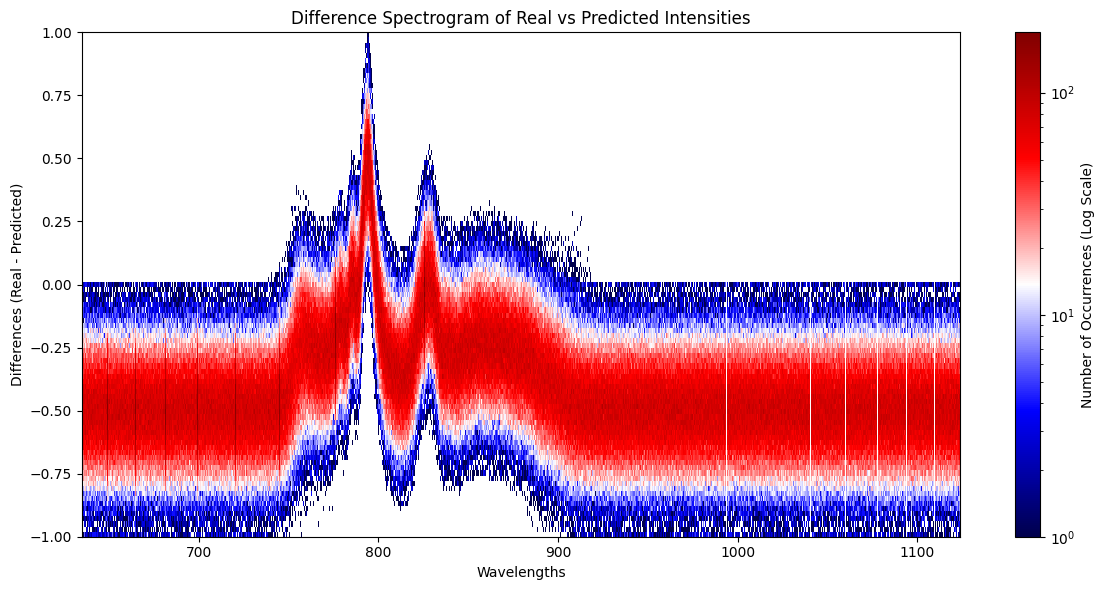

In [26]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

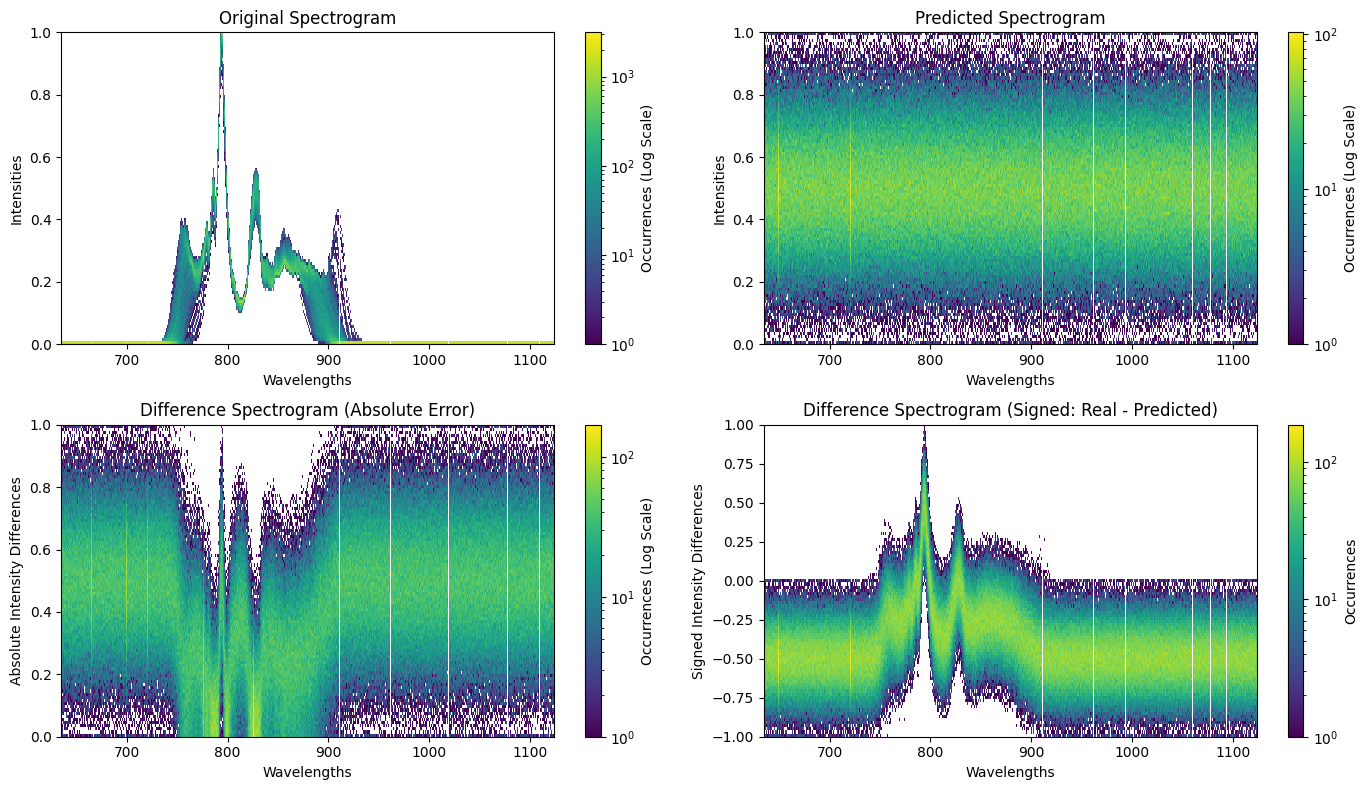

In [27]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

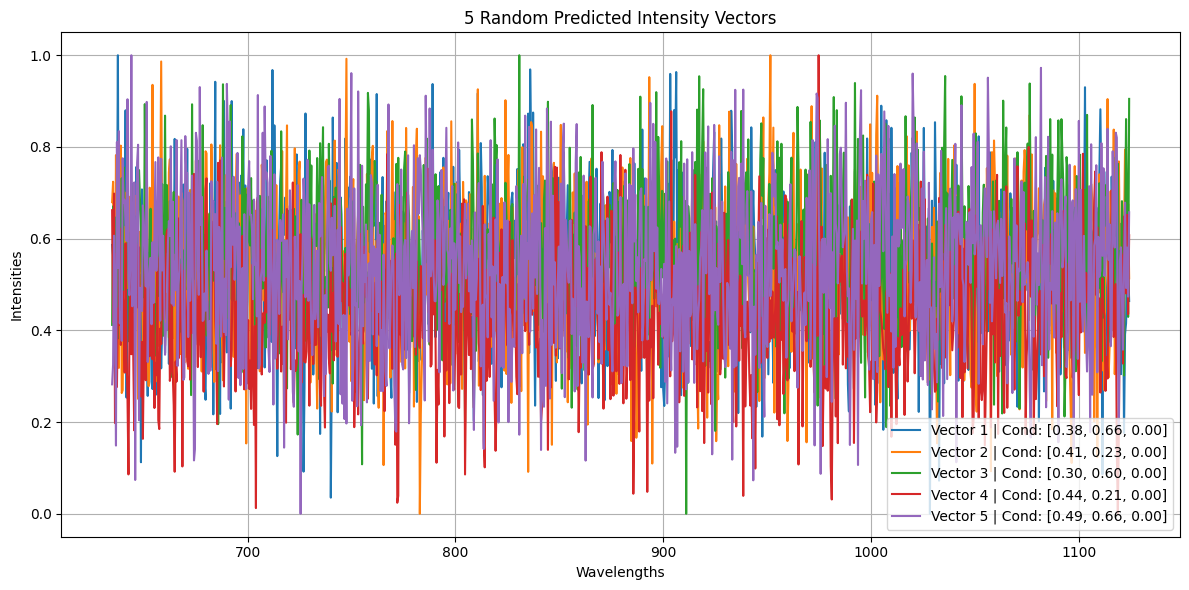

In [28]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

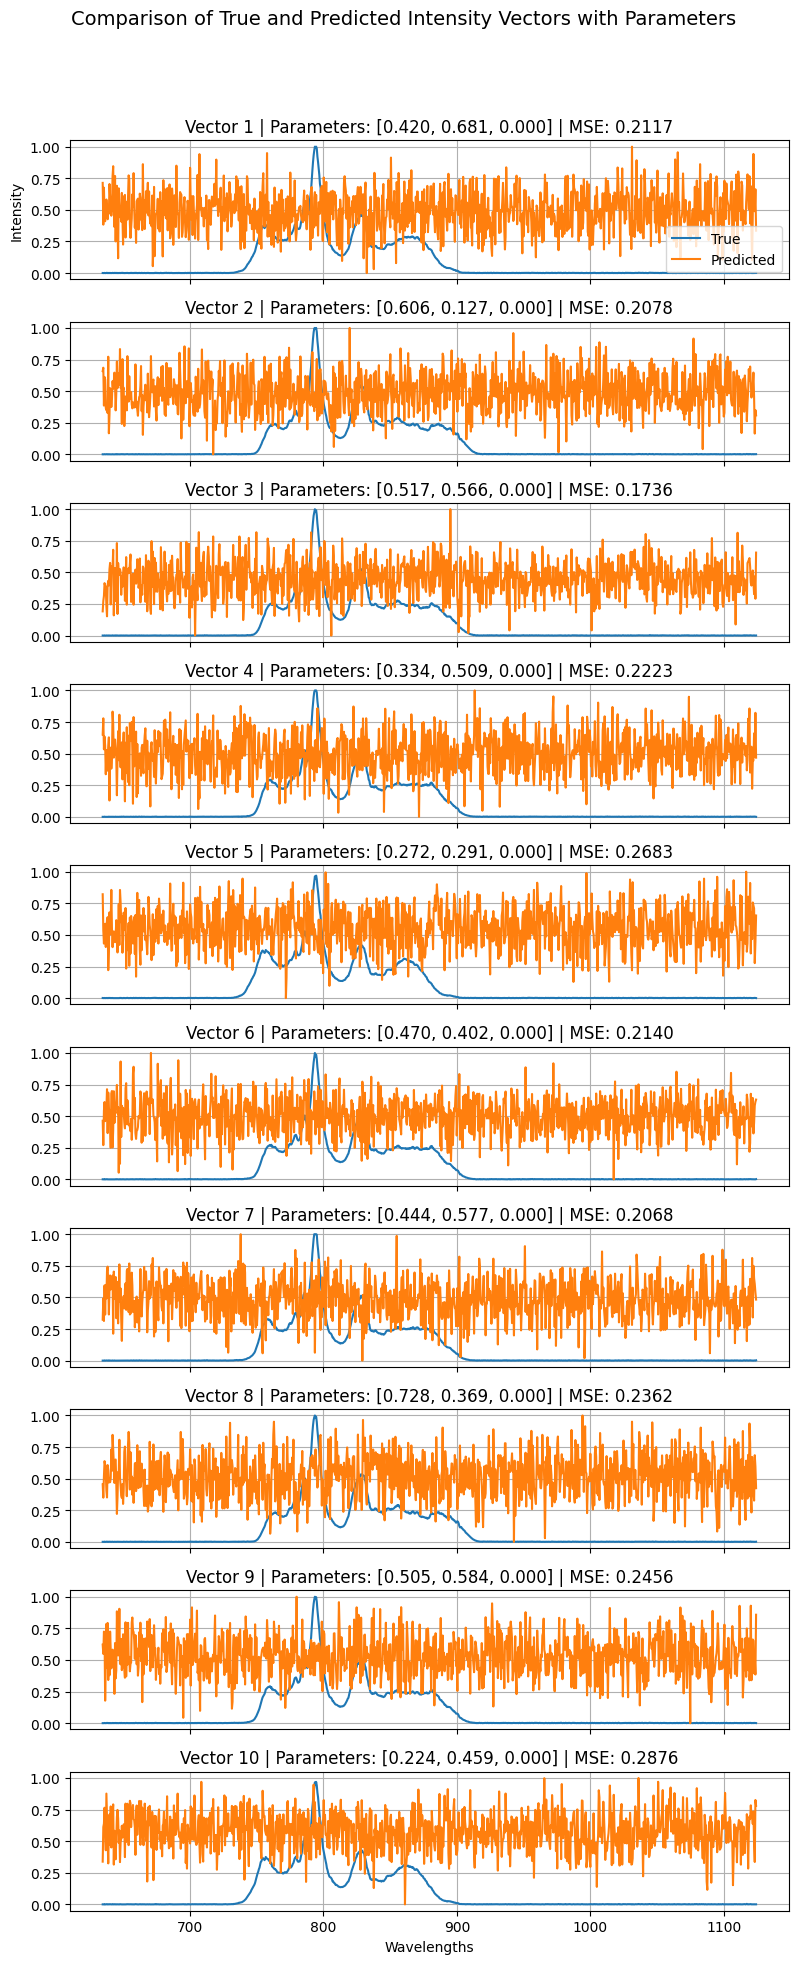

In [29]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

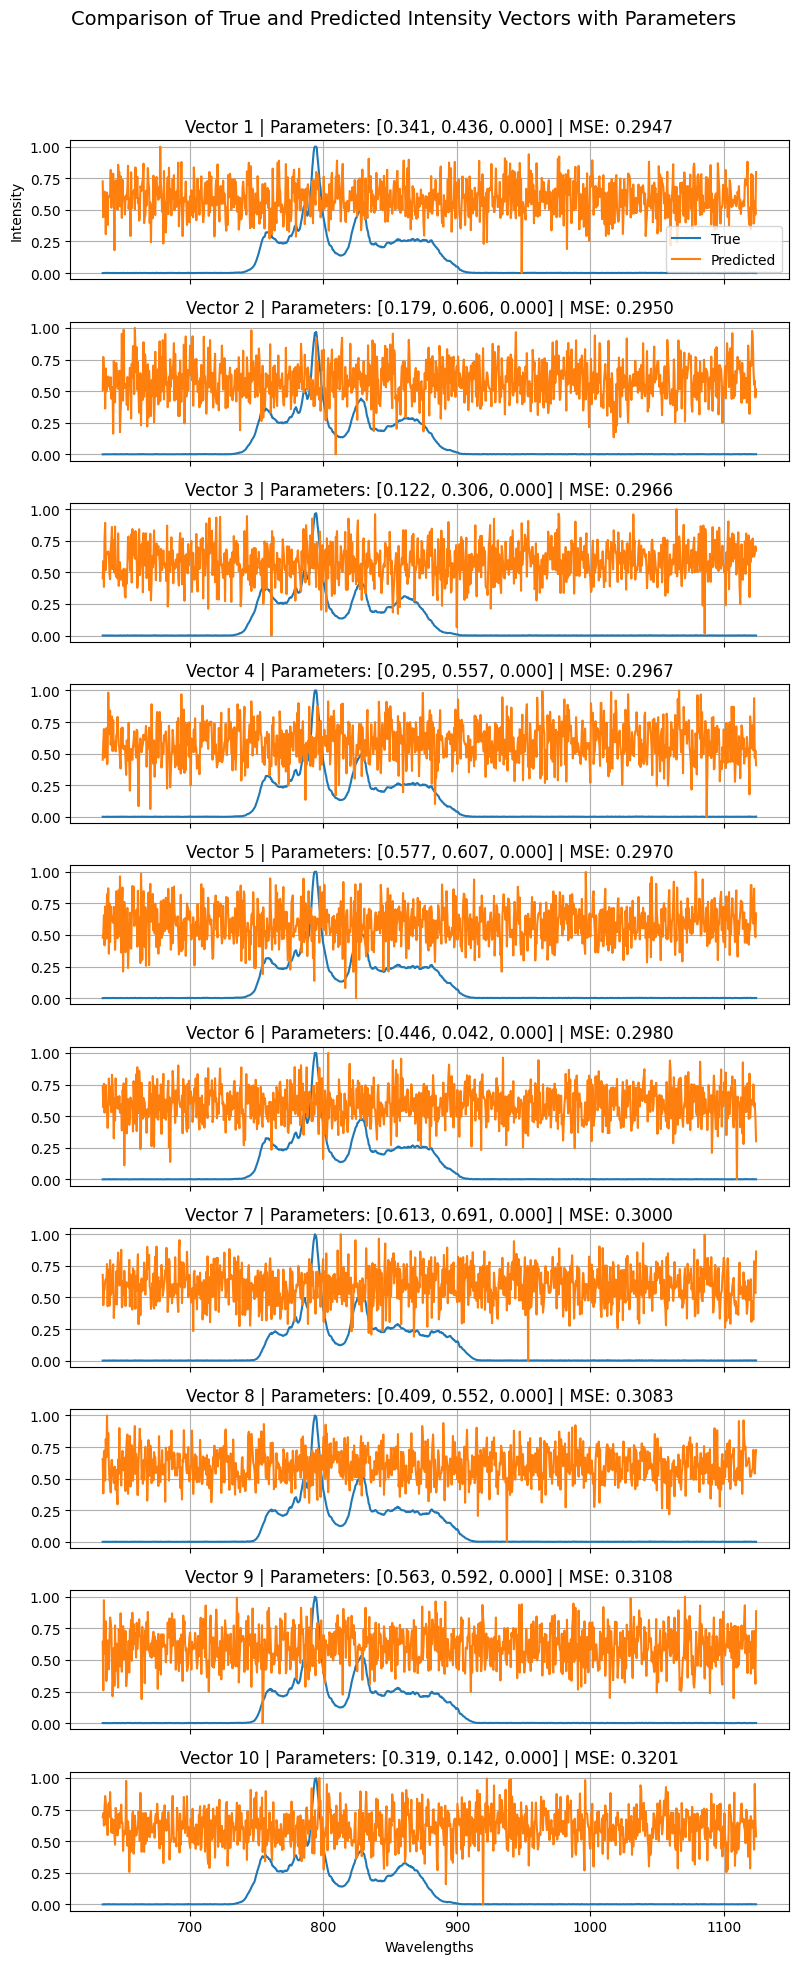

In [30]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.2188
Median: 0.2191
Standard Deviation: 0.0294
Min: 0.1267
Max: 0.3201
Range: 0.1934
Median (Q2): 0.2191
First Quartile (Q1): 0.1985
Third Quartile (Q3): 0.2377
Interquartile Range (IQR): 0.0392
Upper Whisker: 0.2965
Number of Outliers: 10.0000
Outliers: [0.2979583368060934, 0.2965759938114214, 0.2970315454503951, 0.32009035026311605, 0.13179058319502374, 0.3000335992129626, 0.308267737443964, 0.310824919094661, 0.12666203881772584, 0.2967223351647354]


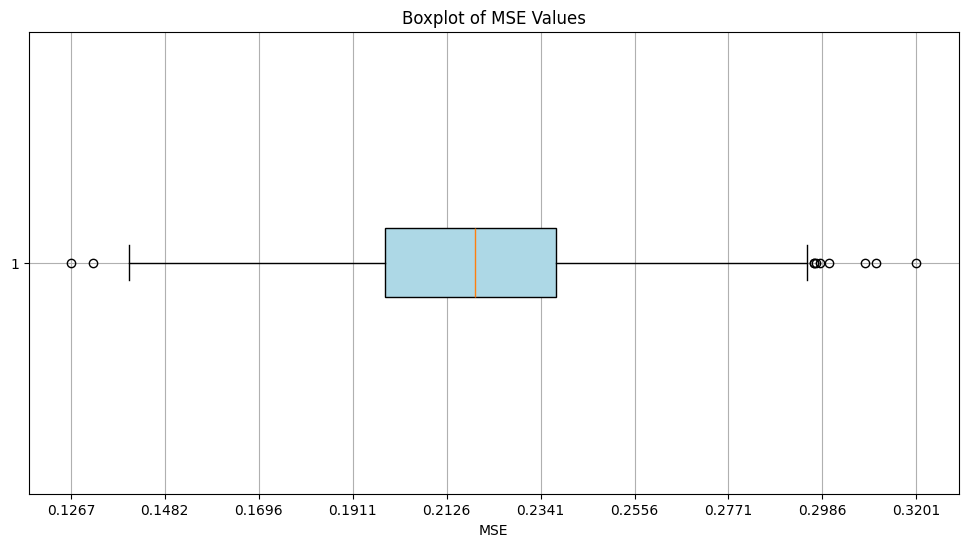

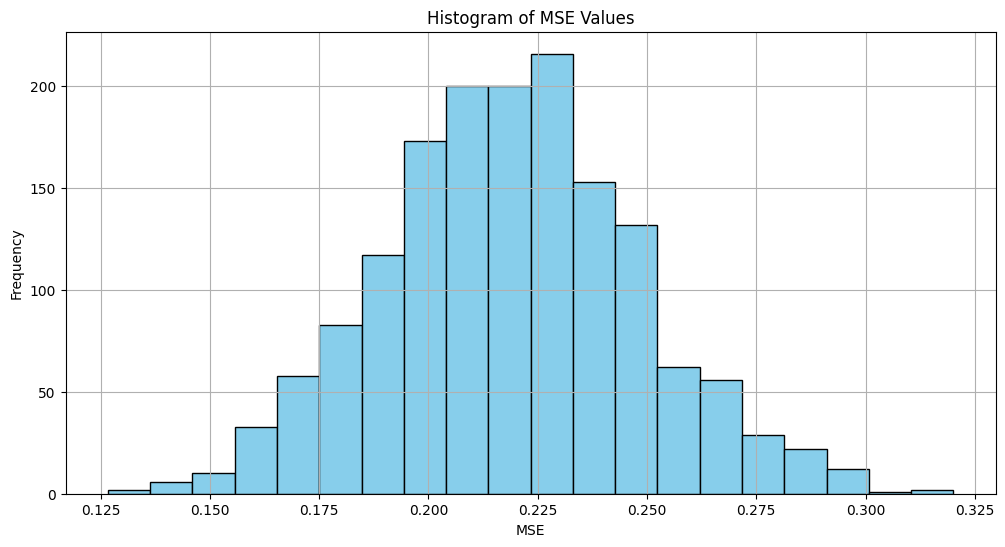

In [31]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 8
Number of vectors with low MSE (below or equal to upper whisker): 1559

Statistics for high MSE conditional vectors:
  Mean: [0.41817376 0.4361491  0.        ]
  Median: [0.42797792 0.55465403 0.        ]
  Std: [0.15722904 0.22513266 0.        ]
  Min: [0.12174653 0.04198878 0.        ]
  Max: [0.61304098 0.69104528 0.        ]

Statistics for low MSE conditional vectors:
  Mean: [0.441639   0.45706722 0.00641246]
  Median: [0.41639015 0.46973595 0.        ]
  Std: [0.16845236 0.21299704 0.04948774]
  Min: [0.         0.00644275 0.        ]
  Max: [1.         1.         0.64880955]


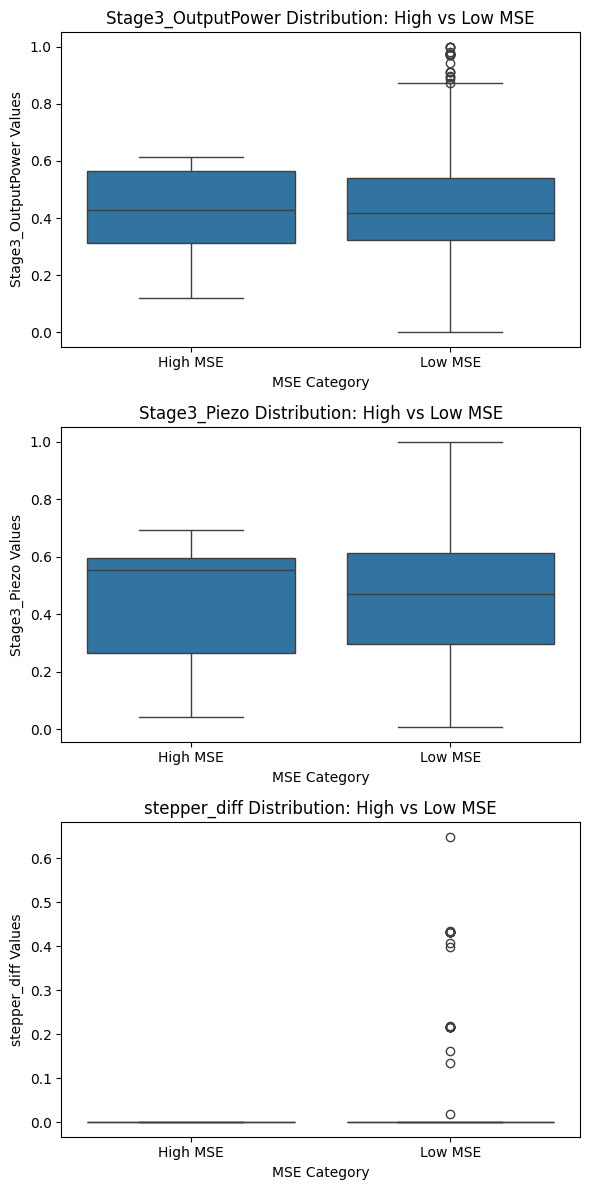

In [32]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [36]:
df = pd.read_csv("../../data/test_data_1024.csv")
df_subset = df.head(20)
new_cond_vectors = np.array([
    [ 214935.09855301,  269804.25447773, -418456.16068934],
    [ -93975.81857062,  120292.39937219,   82977.52669794],
    [ -93975.81857062,  -120292.39937219,   82977.52669794],
    [0,   0,   0],
    [  1,   1,  1],
    
    [ 1,    0,   0],
    [ 0,    1,   0],
    [ 0,    0,   1],
    [1,   1,   0],
    [  0,   1,  1],
    
    [ 1,    0,   1],
    [ 0.1,    0.1,   0],
    [ 0.3,    0.3,   0],
    [ 0.5,    0.5,   0],
    [ 0.7,    0.7,   0],
    
    [ 0.9,    0.9,   0],
    [ 0.1,    0.9,   0],
    [ 0.9,    0.1,   0],
    [ 0.5,    0.3,   0],
    [ 0.3,    0.5,   0],

])

df_subset['cond_vector'] = new_cond_vectors.tolist()
df_subset.to_csv("../../data/data_nonsense.csv", index=False)

/tmp/ipykernel_2285539/2430717549.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cond_vector'] = new_cond_vectors.tolist()


In [37]:
df_subset

time  idx  \
0   2024-06-17 10:11:38.558800220   18   
1   2024-06-17 10:20:03.601318836   80   
2   2024-06-17 10:15:08.508659840   48   
3   2024-06-17 10:12:54.698517799   40   
4   2024-06-17 10:17:33.703059673   57   
5   2024-06-17 10:23:07.478772640  116   
6   2024-06-17 10:25:01.330039501  119   
7   2024-06-17 10:16:29.521095276   57   
8   2024-06-17 10:13:30.400424957   40   
9   2024-06-17 10:22:44.214152813  101   
10  2024-06-17 10:25:20.464485168  119   
11  2024-06-17 10:27:21.985653877  142   
12  2024-06-17 10:09:04.601930618    2   
13  2024-06-17 10:11:55.310579777   18   
14  2024-06-17 10:22:49.936273098  101   
15  2024-06-17 10:20:50.801644802   90   
16  2024-06-17 10:27:51.689198017  142   
17  2024-06-17 10:20:47.782262802   84   
18  2024-06-17 10:16:21.405426979   57   
19  2024-06-17 10:09:18.064522743    2   

                                          cond_vector  \
0   [214935.09855301, 269804.25447773, -418456.160...   
1   [-93975.81857062, 120292.39937219, 82977.52669...   
2   [-93975.81857062, -120292.39937219, 82977.5266...   
3                                     [0.0, 0.0, 0.0]   
4                                     [1.0, 1.0, 1.0]   
5                                     [1.0, 0.0, 0.0]   
6                                     [0.0, 1.0, 0.0]   
7                                     [0.0, 0.0, 1.0]   
8                                     [1.0, 1.0, 0.0]   
9                                     [0.0, 1.0, 1.0]   
10                                    [1.0, 0.0, 1.0]   
11                                    [0.1, 0.1, 0.0]   
12                                    [0.3, 0.3, 0.0]   
13                                    [0.5, 0.5, 0.0]   
14                                    [0.7, 0.7, 0.0]   
15                                    [0.9, 0.9, 0.0]   
16                                    [0.1, 0.9, 0.0]   
17                                    [0.9, 0.1, 0.0]   
18                                    [0.5, 0.3, 0.0]   
19                                    [0.3, 0.5, 0.0]   

                                          intensities  
0   0.0006157916174009492,0.0,0.0,0.00149204461740...  
1   0.0008705681707713021,0.0,0.0,0.00174682117077...  
2   0.00010623851066024335,0.0005403818340281786,0...  
3   0.0008705681707713021,3.082872728747282e-05,0....  
4   0.00036101506403059627,0.0,0.0,0.0012372680640...  
5   0.0008705681707713021,0.0,0.0,0.00174682117077...  
6   0.001125344724141655,0.0,0.0,0.003020703937629...  
7   0.00036101506403059627,0.0,0.0,0.0007277149572...  
8   0.0008705681707713021,0.0,0.0,0.00225637427751...  
9   0.00010623851066024335,0.00028560528065782573,...  
10  0.00036101506403059627,0.0,0.0,0.0020015977241...  
11  0.00036101506403059627,0.0,0.0,0.0017468211707...  
12  0.00010623851066024335,0.0,0.0,0.0012372680640...  
13  0.001125344724141655,0.0,0.0,0.001492044617407...  
14  0.00036101506403059627,0.0,0.0,0.0020015977241...  
15  0.0,0.0,0.0,0.0030207039376297213,0.0,0.0,0.00...  
16  0.00010623851066024335,0.0,0.0,0.0017468211707...  
17  0.00010623851066024335,0.0,0.0,0.0025111508308...  
18  0.0008705681707713021,0.0,0.0,0.00174682117077...  
19  0.00010623851066024335,0.0,0.0,0.0025111508308...

In [44]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../../data/data_nonsense.csv")
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

Testing loop: 100%|███████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.82s/it]


In [45]:
predictions_nonsense

array([[0.51973099, 0.23399197, 0.93195283, ..., 0.43393743, 0.47687089,
        0.43457043],
       [0.38056225, 0.18075053, 0.55359119, ..., 0.42468441, 0.60873294,
        0.45910969],
       [0.51063496, 0.54901195, 0.70462084, ..., 0.73503232, 0.47056276,
        0.62934971],
       ...,
       [0.70364362, 0.42361706, 0.38954005, ..., 0.39436862, 0.43746409,
        0.50922358],
       [0.2461392 , 0.24688342, 0.40728584, ..., 0.38140494, 0.33264485,
        0.61751831],
       [0.40736476, 0.47976363, 0.67790174, ..., 0.2173963 , 0.5773226 ,
        0.30886388]])

In [46]:
x_real_nonsense

array([[6.15791592e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.81409006e-03, 1.07042794e-03, 1.06402254e-03],
       [8.70568154e-04, 0.00000000e+00, 0.00000000e+00, ...,
        7.94983876e-04, 1.83475751e-03, 2.99692882e-04],
       [1.06238513e-04, 5.40381821e-04, 0.00000000e+00, ...,
        0.00000000e+00, 8.15651321e-04, 1.06402254e-03],
       ...,
       [1.06238513e-04, 0.00000000e+00, 0.00000000e+00, ...,
        2.85430753e-04, 8.15651321e-04, 0.00000000e+00],
       [8.70568154e-04, 0.00000000e+00, 0.00000000e+00, ...,
        3.06542061e-05, 1.07042794e-03, 1.57357566e-03],
       [1.06238513e-04, 0.00000000e+00, 0.00000000e+00, ...,
        2.85430753e-04, 5.13216801e-05, 4.49163417e-05]])

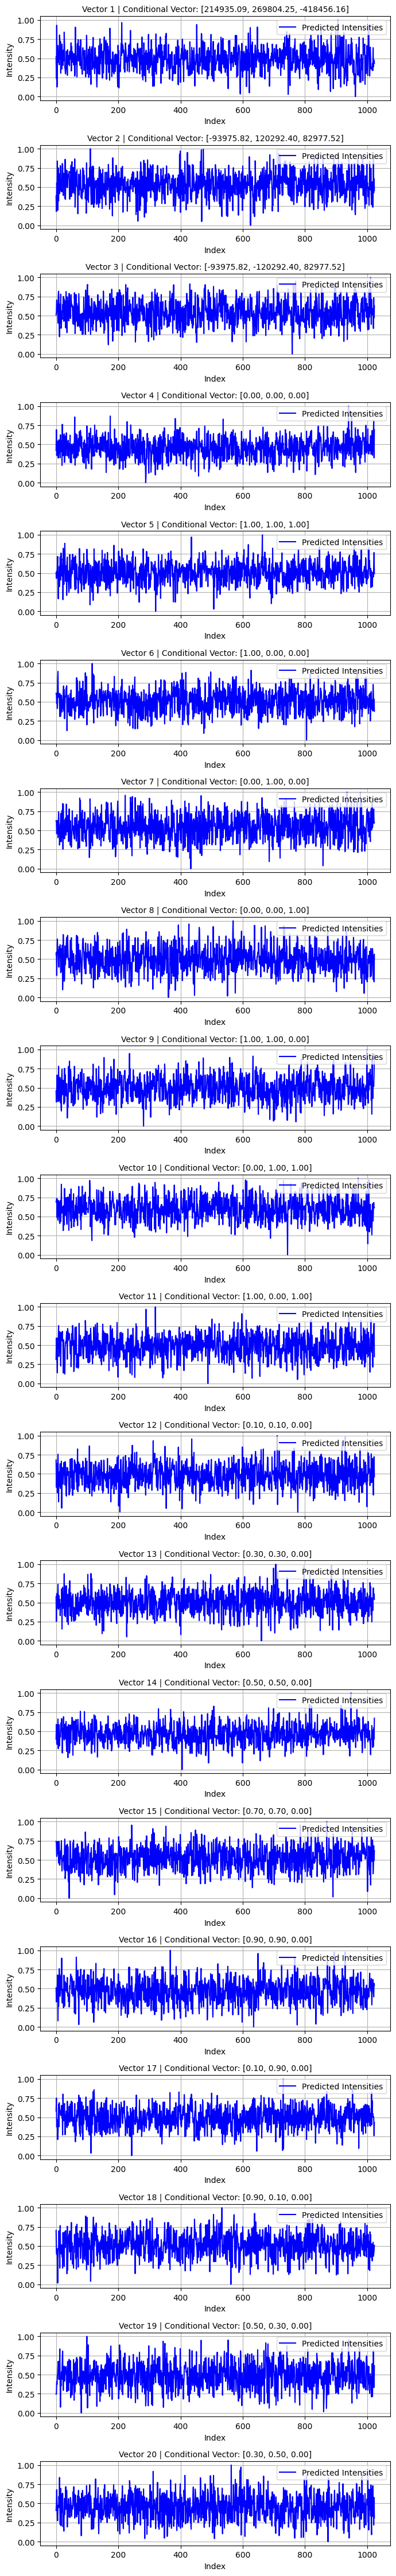

In [47]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense)